In [2]:
#imports
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV



## Load and Normalize Data

In [54]:
#Load Data
merged_data_clean_relevant = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/merged_data_clean_relevant.csv")
relationship_status = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/relationship_status.csv")
age_group = pd.read_csv("../Behavioural_Data_MPILMBB_LEMON/age_group.csv")

print(relationship_status.sum())
print(merged_data_clean_relevant)

Relationship_Status    156
dtype: int64
     LPS_1  TAP_WM_1  TAP_WM_6  CERQ_SelfBlame  CERQ_Acceptance  \
0       27     613.0        15        2.333333         1.666667   
1       24     693.0        13        1.666667         2.666667   
2       25     551.0        15        2.000000         2.666667   
3       17     705.0        14        2.000000         1.666667   
4       20     509.0         8        1.666667         3.333333   
..     ...       ...       ...             ...              ...   
219     23     420.0        13        2.000000         2.000000   
220     23     420.0        13        2.000000         2.000000   
221     23     420.0        13        2.000000         2.000000   
222     23     420.0        13        2.000000         2.000000   
223     20     585.0        15        2.000000         2.666667   

     CERQ_Rumination  CERQ_positiveRefocusing  CERQ_RefocusOnPlanning  \
0           2.000000                 1.000000                1.333333   
1        

In [55]:
#normalize data
scaler = RobustScaler()
merged_data_clean_scaled = scaler.fit_transform(merged_data_clean_relevant)

#Dataframe with normalized columsn and header
merged_data_clean_scaled_dataframe = pd.DataFrame(merged_data_clean_scaled, columns=merged_data_clean_relevant.columns)


## Train-/Test-Split


In [5]:
relationship_array = relationship_status["Relationship_Status"]

In [6]:
# Split into training and test sets by keeping the ration of people in a relationship to people not the same for training and test set. 
X_train, X_test, Y_train, Y_test = train_test_split(merged_data_clean_scaled, relationship_array, test_size=0.2, stratify=relationship_array, random_state=42)

In [7]:
# Optional: Check class proportions

print("Class distribution in y_train:", dict(zip(*np.unique(Y_train, return_counts=True))))
print("Class distribution in y_test:", dict(zip(*np.unique(Y_test, return_counts=True))))

Class distribution in y_train: {0: 54, 1: 125}
Class distribution in y_test: {0: 14, 1: 31}


## Training

### Logistic Regression

In [8]:
#set up learning function 
#set up cross validation. 
# Train

# set hyperparameters
n_folds = 10
n_alphas = 10
max_iter = 5000

# define models
ridge_model = LogisticRegressionCV(penalty="l2", n_jobs = 16, max_iter=max_iter, fit_intercept=False, random_state=1, solver='saga', cv=n_folds, Cs=n_alphas)

# INSERT YOUR CODE HERE
logreg_ridge_cv = ridge_model.fit(X_train, Y_train)

In [9]:
# Cross-validated accuracy scores for each fold
cv_scores = logreg_ridge_cv.scores_[1]  # For the positive class (1)

# Mean accuracy across folds
mean_cv_accuracy = cv_scores.mean()

# Print the cross-validated accuracy
print(f"Mean cross-validated accuracy: {mean_cv_accuracy:.4f}")

Mean cross-validated accuracy: 0.6384


### Random Forest

#### Model Training using GridSearch with Cross Validation

In [10]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'n_estimators': [10, 25, 50, 100, 150],
    'max_features': ['sqrt', 'log2',None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42), #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    param_grid=param_grid,
    cv=5,       # Cross-validation folds
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, Y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 150}


#### Evaluation on Test Set

In [11]:
# Use the best model for predictions
best_rf_model = grid_search.best_estimator_

# Test Model on Test Set
y_pred = best_rf_model.predict(X_test)

# Evaluate the best model
results = classification_report(Y_test, y_pred, output_dict=True)
print(results)
print("weighted average F1 Score: " + str(results["weighted avg"]["f1-score"]))


{'0': {'precision': 0.6, 'recall': 0.42857142857142855, 'f1-score': 0.5, 'support': 14.0}, '1': {'precision': 0.7714285714285715, 'recall': 0.8709677419354839, 'f1-score': 0.8181818181818182, 'support': 31.0}, 'accuracy': 0.7333333333333333, 'macro avg': {'precision': 0.6857142857142857, 'recall': 0.6497695852534562, 'f1-score': 0.6590909090909092, 'support': 45.0}, 'weighted avg': {'precision': 0.7180952380952381, 'recall': 0.7333333333333333, 'f1-score': 0.7191919191919193, 'support': 45.0}}
weighted average F1 Score: 0.7191919191919193


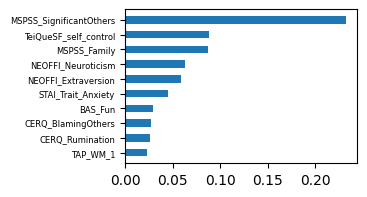

In [151]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': merged_data_clean_scaled_dataframe.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

#feature_importances = feature_importances.head(10)
feature_importances = feature_importances[-10:]

# Plot
plt.figure(figsize=(3, 2))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], height=0.5)
plt.yticks(fontsize=6) 
plt.show()

In [123]:
print(feature_importances.shape)

(45, 2)


In [122]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, classification_report

# Dummy Classifier Training with Cross-Validation
def train_dummy_classifier_cv(X_train, Y_train, X_test, Y_test, cv=5):
    # Initialize Dummy Classifier
    dummy_clf = DummyClassifier(strategy="stratified")  # Predicts the most frequent class

    # Perform Cross-Validation
    cv_scores = cross_val_score(dummy_clf, X_train, Y_train, cv=cv, scoring="f1_weighted")

    # Train on full dataset to generate a classification report
    dummy_clf.fit(X_train, Y_train)

    #Predict on Test Set
    y_pred_dummy = dummy_clf.predict(X_test)
    dummy_report = classification_report(Y_test, y_pred_dummy, output_dict=True)
    
    print("Dummy Classifier Cross-Validation Performance:")
    print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (± {cv_scores.std():.4f})")
    print(dummy_report)
    print("weighted average F1 Score: " + str(dummy_report["weighted avg"]["f1-score"]))
    
    return cv_scores, dummy_report

# Train Dummy Classifier using Cross-Validation
dummy_cv_scores, dummy_cv_report = train_dummy_classifier_cv(X_train, Y_train, X_test, Y_test, cv=5)

Dummy Classifier Cross-Validation Performance:
Mean CV Accuracy: 0.5869 (± 0.0560)
{'0': {'precision': 0.2777777777777778, 'recall': 0.35714285714285715, 'f1-score': 0.31250000000000006, 'support': 14.0}, '1': {'precision': 0.6666666666666666, 'recall': 0.5806451612903226, 'f1-score': 0.6206896551724138, 'support': 31.0}, 'accuracy': 0.5111111111111111, 'macro avg': {'precision': 0.4722222222222222, 'recall': 0.46889400921658986, 'f1-score': 0.46659482758620696, 'support': 45.0}, 'weighted avg': {'precision': 0.545679012345679, 'recall': 0.5111111111111111, 'f1-score': 0.524808429118774, 'support': 45.0}}
weighted average F1 Score: 0.524808429118774


## Analysis of Important Features

In [16]:
# Define parameter grid
merged_data_clean_scaled_dataframe_ohne_MSPSS = merged_data_clean_scaled_dataframe.drop(columns=["MSPSS_SignificantOthers"])

merged_data_clean_relevant_MSPSS = merged_data_clean_relevant.drop(columns=["MSPSS_SignificantOthers"])
#normalize data
scaler = RobustScaler()
merged_data_clean_scaled_MSPSS = scaler.fit_transform(merged_data_clean_relevant_MSPSS)

#Dataframe with normalized columsn and header
merged_data_clean_scaled_dataframe_MSPSS = pd.DataFrame(merged_data_clean_scaled_MSPSS, columns=merged_data_clean_relevant_MSPSS.columns)

X_train_MSPSS, X_test_MSPSS, Y_train_MSPSS, Y_test_MSPSS = train_test_split(merged_data_clean_scaled_MSPSS, relationship_array, test_size=0.2, stratify=relationship_array, random_state=42)

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'n_estimators': [10, 25, 50, 100, 150],
    'max_features': ['sqrt', 'log2',None]
}

# Initialize GridSearchCV
grid_search_2 = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42), #The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))
    param_grid=param_grid,
    cv=5,       # Cross-validation folds
    scoring='f1_weighted',
    n_jobs=-1
)

# Fit the model
grid_search_2.fit(X_train_MSPSS, Y_train_MSPSS)

# Best Parameters
print("Best Parameters:", grid_search_2.best_params_)

best_model_MSPSS = grid_search_2.best_estimator_
# Test Model on Test Set
y_pred_2 = best_model_MSPSS.predict(X_test_MSPSS)

# Evaluate the best model
results = classification_report(Y_test_MSPSS, y_pred_2, output_dict=True)
print(results)
print("weighted average F1 Score: " + str(results["weighted avg"]["f1-score"]))


Best Parameters: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
{'0': {'precision': 0.5555555555555556, 'recall': 0.35714285714285715, 'f1-score': 0.43478260869565216, 'support': 14.0}, '1': {'precision': 0.75, 'recall': 0.8709677419354839, 'f1-score': 0.8059701492537312, 'support': 31.0}, 'accuracy': 0.7111111111111111, 'macro avg': {'precision': 0.6527777777777778, 'recall': 0.6140552995391705, 'f1-score': 0.6203763789746917, 'support': 45.0}, 'weighted avg': {'precision': 0.6895061728395062, 'recall': 0.7111111111111111, 'f1-score': 0.6904895810801066, 'support': 45.0}}
weighted average F1 Score: 0.6904895810801066


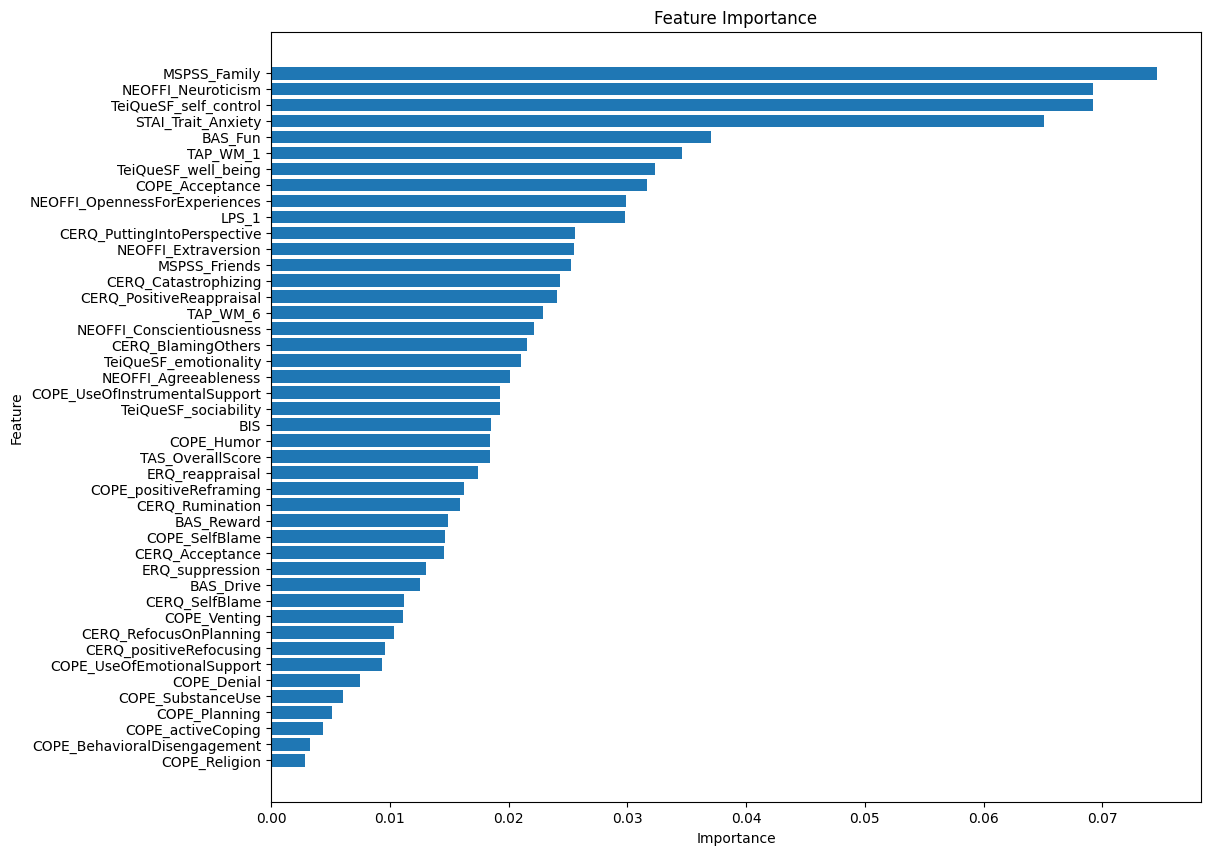

In [17]:
# Feature Importance
feature_importances_wo_MSPSS = pd.DataFrame({
    'Feature': merged_data_clean_scaled_dataframe_MSPSS.columns,
    'Importance': best_model_MSPSS.feature_importances_
}).sort_values(by='Importance', ascending=True)

# Plot
plt.figure(figsize=(12, 10))
plt.barh(feature_importances_wo_MSPSS['Feature'], feature_importances_wo_MSPSS['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [18]:

# Vergleich der Cross-Validation Scores
'''comparison_df = pd.DataFrame({
    "Model": ["With MSPSS_SignificantOthers", "Without MSPSS_SignificantOthers"],
    "Mean Weighted F1 Score": [cv_scores.mean(), cv_scores_filtered.mean()],
    "Standard Deviation": [cv_scores.std(), cv_scores_filtered.std()]
})

print(comparison_df)'''

'comparison_df = pd.DataFrame({\n    "Model": ["With MSPSS_SignificantOthers", "Without MSPSS_SignificantOthers"],\n    "Mean Weighted F1 Score": [cv_scores.mean(), cv_scores_filtered.mean()],\n    "Standard Deviation": [cv_scores.std(), cv_scores_filtered.std()]\n})\n\nprint(comparison_df)'

--------
### Feature Analysis and Importance referring to relationship status

In [48]:
# Convert relationship_status column to a DataFrame
relationship_df = pd.DataFrame(relationship_status["Relationship_Status"].values, columns=["Relationship_Status"])

# Ensure the index of relationship_df matches merged_data_clean_scaled_dataframe
relationship_df.index = merged_data_clean_scaled_dataframe.index  

# Append Relationship_Status as a new column
merged_data_clean_scaled_dataframe["Relationship_Status"] = relationship_df

# Verify if the column was added correctly
#print(merged_data_clean_scaled_dataframe.head())

In [20]:
# Split the dataset into two groups
relationship_yes = merged_data_clean_scaled_dataframe[merged_data_clean_scaled_dataframe["Relationship_Status"] == 1]
relationship_no = merged_data_clean_scaled_dataframe[merged_data_clean_scaled_dataframe["Relationship_Status"] == 0]

# Check the shape of the two groups
print(f"People in a relationship: {relationship_yes.shape[0]}")
print(f"People not in a relationship: {relationship_no.shape[0]}")

relationship_yes.head()

People in a relationship: 156
People not in a relationship: 68


,LPS_1,TAP_WM_1,TAP_WM_6,CERQ_SelfBlame,CERQ_Acceptance,CERQ_Rumination,CERQ_positiveRefocusing,CERQ_RefocusOnPlanning,CERQ_PositiveReappraisal,CERQ_PuttingIntoPerspective,...,COPE_Planning,COPE_Humor,COPE_Acceptance,COPE_Religion,COPE_SelfBlame,BIS,BAS_Drive,BAS_Fun,BAS_Reward,Relationship_Status
1,0.833333,0.677223,-0.333333,0.5,0.25,0.00,-0.25,-1.25,-1.25,-1.50,...,-1.0,-0.5,-0.5,0.0,0.5,0.50,-1.0,-0.5,-2.0,1
2,1.000000,-0.014616,0.333333,1.0,0.25,-0.25,-0.25,0.75,-0.50,-0.50,...,0.5,0.0,0.5,0.0,1.0,1.25,-0.5,0.0,-1.5,1
6,0.833333,-0.306943,0.333333,2.5,-0.25,-0.75,-1.25,1.00,0.75,0.75,...,0.5,-1.0,-0.5,0.0,2.0,1.50,0.5,-0.5,1.0,1
7,0.333333,0.004872,0.000000,4.0,0.50,0.50,-1.00,0.25,-1.50,-1.75,...,-0.5,-1.0,-2.0,0.0,1.5,-1.50,-2.0,-1.5,-2.5,1
8,0.333333,-0.404385,0.000000,1.5,0.50,-0.50,0.00,-1.00,-0.25,0.25,...,-1.0,0.0,-1.0,0.0,0.0,0.00,-1.0,-0.5,-1.0,1


#### Group group specific analysis of most important feature

Top 3 Features for Analysis: ['MSPSS_SignificantOthers', 'TeiQueSF_self_control', 'MSPSS_Family', 'NEOFFI_Neuroticism', 'NEOFFI_Extraversion', 'STAI_Trait_Anxiety']


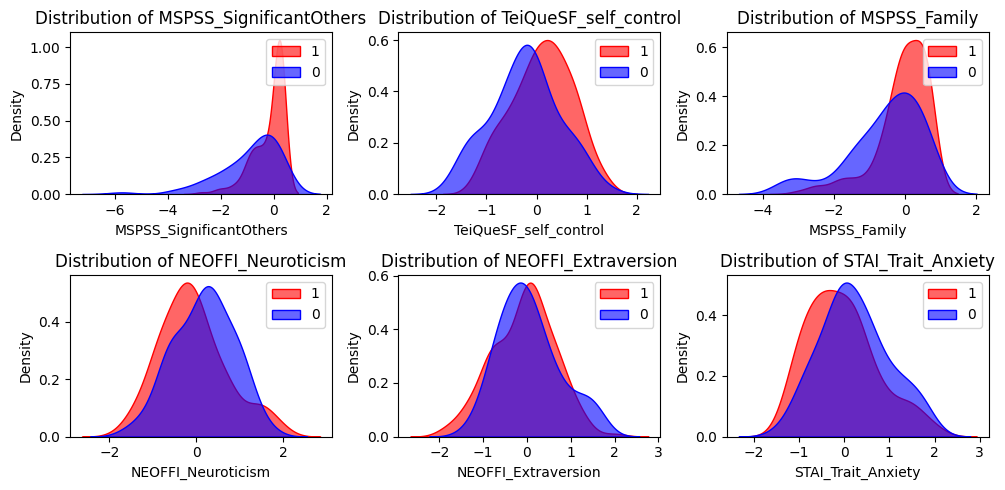

In [76]:
# Extract top 6 feature names
top_6_features = feature_importances.sort_values(by="Importance", ascending=False)["Feature"][:6].tolist()
print("Top 3 Features for Analysis:", top_6_features)

# Set up the figure
plt.figure(figsize=(10, 5))

for i, feature in enumerate(top_6_features):
    plt.subplot(2, 3, i + 1)
    
    # Plot distribution for both groups
    sns.kdeplot(relationship_yes[feature], label="1", fill=True, alpha=0.6, color="red")
    sns.kdeplot(relationship_no[feature], label="0", fill=True, alpha=0.6, color="blue")
    
    # Add title and labels
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()

plt.tight_layout()
plt.show()

In [35]:
X_test_dataframe = pd.DataFrame(X_test, columns=merged_data_clean_relevant.columns) 

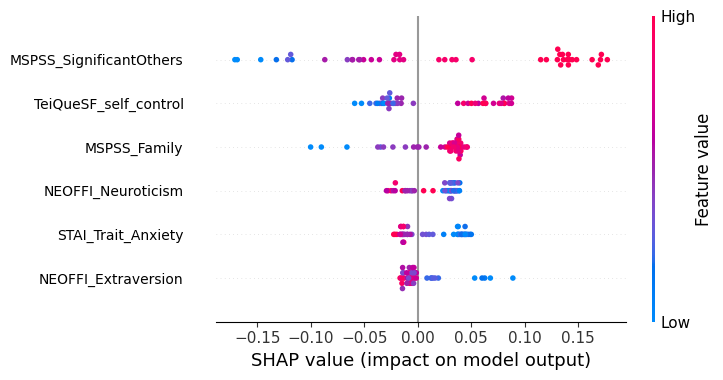

In [161]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Get SHAP values for the training set
shap_values = explainer.shap_values(X_test_dataframe)


# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Get SHAP values for the training set
shap_values = explainer.shap_values(X_test_dataframe)

plt.figure(figsize=(6, 6))  # Adjust figure size if needed
shap.summary_plot(
    shap_values[:,:,1], X_test_dataframe, max_display=6, show=False
)

# Modify y-axis (feature names) font size
plt.gca().tick_params(axis='y', labelsize=10, colors='black')  # Adjust '10' to desired font size
#plt.gca().tick_params(axis='x', labelsize=8) 

SHAP values for predicting whether a person is in a relationship, showing how the six most important features influence the model’s output. Positive SHAP values indicate a positive impact on the prediction, while negative values indicate a negative impact. The magnitude reflects the strength of the effect.

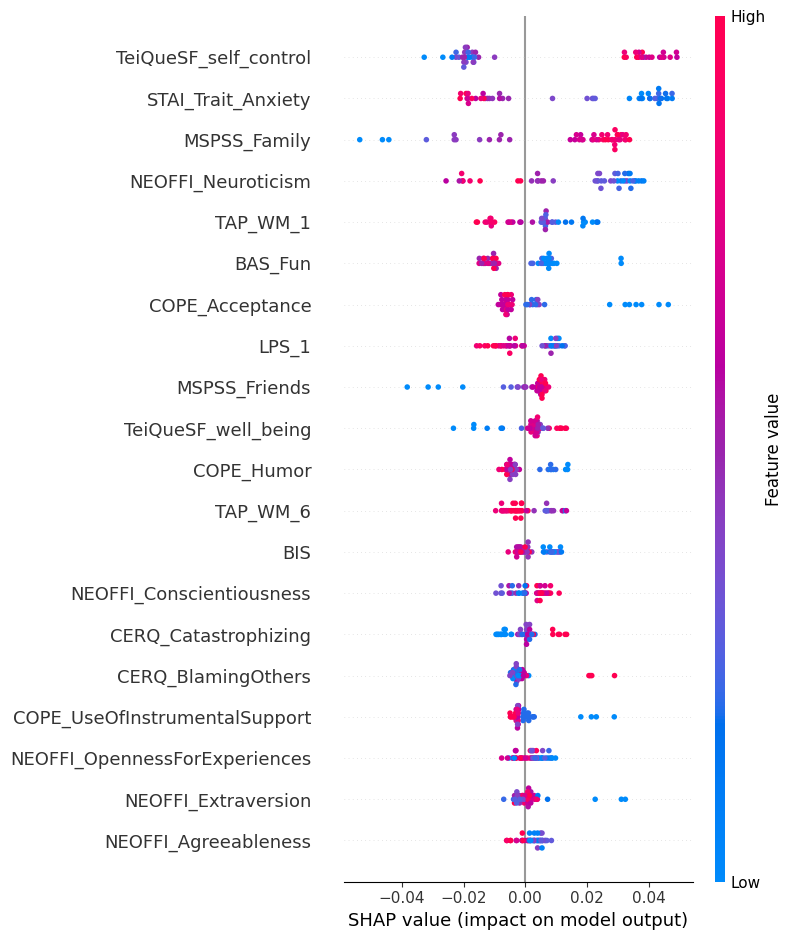

In [47]:
X_test_MSPSS_dataframe = pd.DataFrame(X_test_MSPSS, columns=merged_data_clean_scaled_dataframe_ohne_MSPSS.columns) 
explainer_2 = shap.TreeExplainer(best_model_MSPSS)

# Get SHAP values for the training set
shap_values = explainer_2.shap_values(X_test_MSPSS_dataframe)

# Plot SHAP feature importance for the class 0 (for multi-class classification, you can iterate over all classes)
#shap.summary_plot(shap_values[:,:,0], X_test)  # Plot for class 0
shap.summary_plot(shap_values[:,:,1], X_test_MSPSS_dataframe) 

### T-Test - Test for statistical difference in distributions

In [79]:
from scipy.stats import ttest_ind

t_results = {}
for feature in top_6_features:
    stat, p_val = ttest_ind(relationship_yes[feature], relationship_no[feature], equal_var=False)
    t_results[feature] = {'t-stat': stat, 'p-value': p_val}

# Display results
for col, res in t_results.items():
    print(f"Variable: {col}, t-stat: {res['t-stat']}, p-value: {res['p-value']:.4f}")

print(t_results)

Variable: MSPSS_SignificantOthers, t-stat: 4.955521516856667, p-value: 0.0000
Variable: TeiQueSF_self_control, t-stat: 3.6266273893334184, p-value: 0.0004
Variable: MSPSS_Family, t-stat: 3.5454577486616716, p-value: 0.0006
Variable: NEOFFI_Neuroticism, t-stat: -2.3585671949399742, p-value: 0.0197
Variable: NEOFFI_Extraversion, t-stat: -1.2334430841887045, p-value: 0.2196
Variable: STAI_Trait_Anxiety, t-stat: -2.5780067389874226, p-value: 0.0110
{'MSPSS_SignificantOthers': {'t-stat': 4.955521516856667, 'p-value': 3.7532796037267123e-06}, 'TeiQueSF_self_control': {'t-stat': 3.6266273893334184, 'p-value': 0.0004299888710999026}, 'MSPSS_Family': {'t-stat': 3.5454577486616716, 'p-value': 0.0006040660204353903}, 'NEOFFI_Neuroticism': {'t-stat': -2.3585671949399742, 'p-value': 0.019690503996964193}, 'NEOFFI_Extraversion': {'t-stat': -1.2334430841887045, 'p-value': 0.21964315494666029}, 'STAI_Trait_Anxiety': {'t-stat': -2.5780067389874226, 'p-value': 0.011046894676349502}}


### Mann-Whitney U Test

The Mann-Whitney U Test is a statistical test used to determine if there is a significant difference between the distributions of two independent groups on a continuous variable. It is particularly useful when the data are not normally distributed. The test compares the ranks of values between the two groups rather than their actual values, making it non-parametric. The test calculates a U-statistic, which is then used to determine a p-value. A small p-value (typically less than 0.05) indicates that the two groups are likely to differ significantly in terms of the variable being measured, such as self-control scores between people in relationships and those not in relationships.


In [80]:
from scipy.stats import mannwhitneyu

results_mannwhitneyu = {}
for feature in top_6_features:
    stat, p_val = mannwhitneyu(relationship_yes[feature], relationship_no[feature],alternative='two-sided')
    results_mannwhitneyu[feature] = {'U-stat': stat, 'p-value': p_val}

# Display results
for col, res in results_mannwhitneyu.items():
    print(f"Variable: {col}, t-stat: {res['U-stat']}, p-value: {res['p-value']:.4f}")

Variable: MSPSS_SignificantOthers, t-stat: 7692.5, p-value: 0.0000
Variable: TeiQueSF_self_control, t-stat: 6882.5, p-value: 0.0004
Variable: MSPSS_Family, t-stat: 6901.5, p-value: 0.0003
Variable: NEOFFI_Neuroticism, t-stat: 4090.5, p-value: 0.0065
Variable: NEOFFI_Extraversion, t-stat: 5019.0, p-value: 0.5229
Variable: STAI_Trait_Anxiety, t-stat: 4093.0, p-value: 0.0066


The Result of the T-Test and Mann-Whitney U Test suggest that there is a significant difference in distributions for the top 6 Features. Certainly! Here's the combined interpretation in one cohesive text:

---
In this analysis, we compared the means of two groups, **"In Relationship"** vs. **"Not in Relationship"**, across several psychological and social measures. The t-test results, including the t-statistics and p-values, help us determine whether there are significant differences between the two groups for each feature.

The **MSPSS_SignificantOthers** variable showed a substantial difference between the groups, with a t-statistic of 4.96 and a p-value of 0.0000, indicating a **highly significant difference** in perceived social support from significant others. Similarly, **TeiQueSF_self_control** showed a t-statistic of 3.63 and a p-value of 0.0004, confirming a **statistically significant difference** in self-control levels between the two groups. For **MSPSS_Family**, the t-statistic was 3.55 with a p-value of 0.0006, suggesting that people in relationships feel significantly more supported by family compared to those not in relationships. In terms of **NEOFFI_Neuroticism**, the negative t-statistic of -2.36 and a p-value of 0.0197 indicate that people in relationships report **lower neuroticism** compared to those not in relationships. However, for **NEOFFI_Extraversion**, the t-statistic of -1.23 and p-value of 0.2196 revealed **no significant difference**, meaning relationship status did not influence extraversion. Lastly, **STAI_Trait_Anxiety** demonstrated a t-statistic of -2.58 and a p-value of 0.0110, indicating a **significant difference** in trait anxiety between the two groups, with those in relationships having lower anxiety.

Overall, the analysis found significant differences in relationship status on social support, self-control, anxiety, and neuroticism, but no significant difference in extraversion. These findings highlight that relationship status can influence various psychological factors, particularly social support and emotional traits.

---

Top 3 Features for Analysis: ['MSPSS_SignificantOthers', 'TeiQueSF_self_control', 'MSPSS_Family', 'NEOFFI_Neuroticism', 'NEOFFI_Extraversion', 'STAI_Trait_Anxiety']


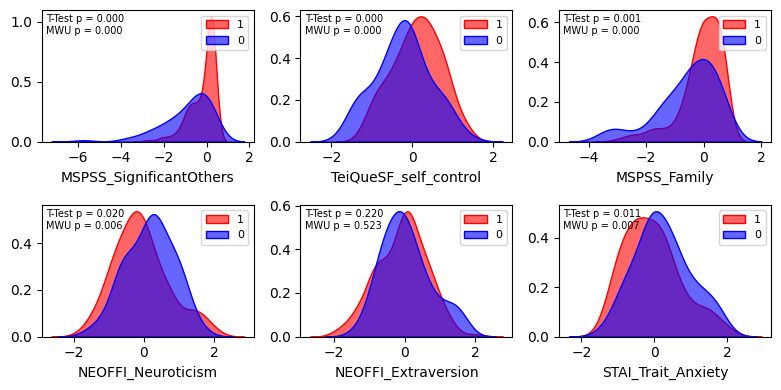

In [114]:
# Extract top 6 feature names
top_6_features = feature_importances.sort_values(by="Importance", ascending=False)["Feature"][:6].tolist()
print("Top 3 Features for Analysis:", top_6_features)

# Set up the figure
plt.figure(figsize=(8, 4))

for i, feature in enumerate(top_6_features):
    plt.subplot(2, 3, i + 1)
    
    # Plot distribution for both groups
    sns.kdeplot(relationship_yes[feature], label="1", fill=True, alpha=0.6, color="red")
    sns.kdeplot(relationship_no[feature], label="0", fill=True, alpha=0.6, color="blue")
    
    # Add title and labels
    plt.xlabel(feature)
    plt.ylabel("")
    plt.legend(fontsize=8, loc="upper right")

        # Retrieve p-value from dictionary
    p_value = results[feature]['p-value']
    p_value_whitney = results_mannwhitneyu[feature]['p-value']
    

    # Add p-values to the plot
    plt.text(
        0.02, 0.82, 
        f"T-Test p = {p_value:.3f}\nMWU p = {p_value_whitney:.3f}",
        transform=plt.gca().transAxes, fontsize=7
    )

plt.tight_layout()
plt.show()

Figure caption: Kernel density estimations (KDEs) for the six most important features based on Random Forest feature importance scores. Distributions are shown for individuals in a relationship (red) and not in a relationship (blue). P-values from a two-sample t-test and a Mann-Whitney U test (α = 0.05) are displayed in the upper left corner of each subplot

--------

### Density referring to the two Age Groups

In [40]:
# Konvertiere age_array in einen DataFrame
age_df = pd.DataFrame(age_group, columns=["Age_Group"])

# Stelle sicher, dass der Index mit merged_data_clean_scaled_dataframe übereinstimmt
age_df.index = merged_data_clean_scaled_dataframe.index  

# Füge Age_Group als neue Spalte hinzu
merged_data_clean_scaled_dataframe["Age_Group"] = age_df

# Überprüfe, ob die Spalte korrekt hinzugefügt wurde
print(merged_data_clean_scaled_dataframe.head())

      LPS_1  TAP_WM_1  TAP_WM_6  CERQ_SelfBlame  CERQ_Acceptance  \
0  1.333333  0.287454  0.333333             1.5            -0.50   
1  0.833333  0.677223 -0.333333             0.5             0.25   
2  1.000000 -0.014616  0.333333             1.0             0.25   
3 -0.333333  0.735688  0.000000             1.0            -0.50   
4  0.166667 -0.219245 -2.000000             0.5             0.75   

   CERQ_Rumination  CERQ_positiveRefocusing  CERQ_RefocusOnPlanning  \
0             0.25                    -0.50                   -1.00   
1             0.00                    -0.25                   -1.25   
2            -0.25                    -0.25                    0.75   
3            -0.25                     0.50                    0.50   
4             0.00                    -0.50                   -1.00   

   CERQ_PositiveReappraisal  CERQ_PuttingIntoPerspective  ...  COPE_Humor  \
0                     -0.25                        -0.75  ...         0.5   
1         

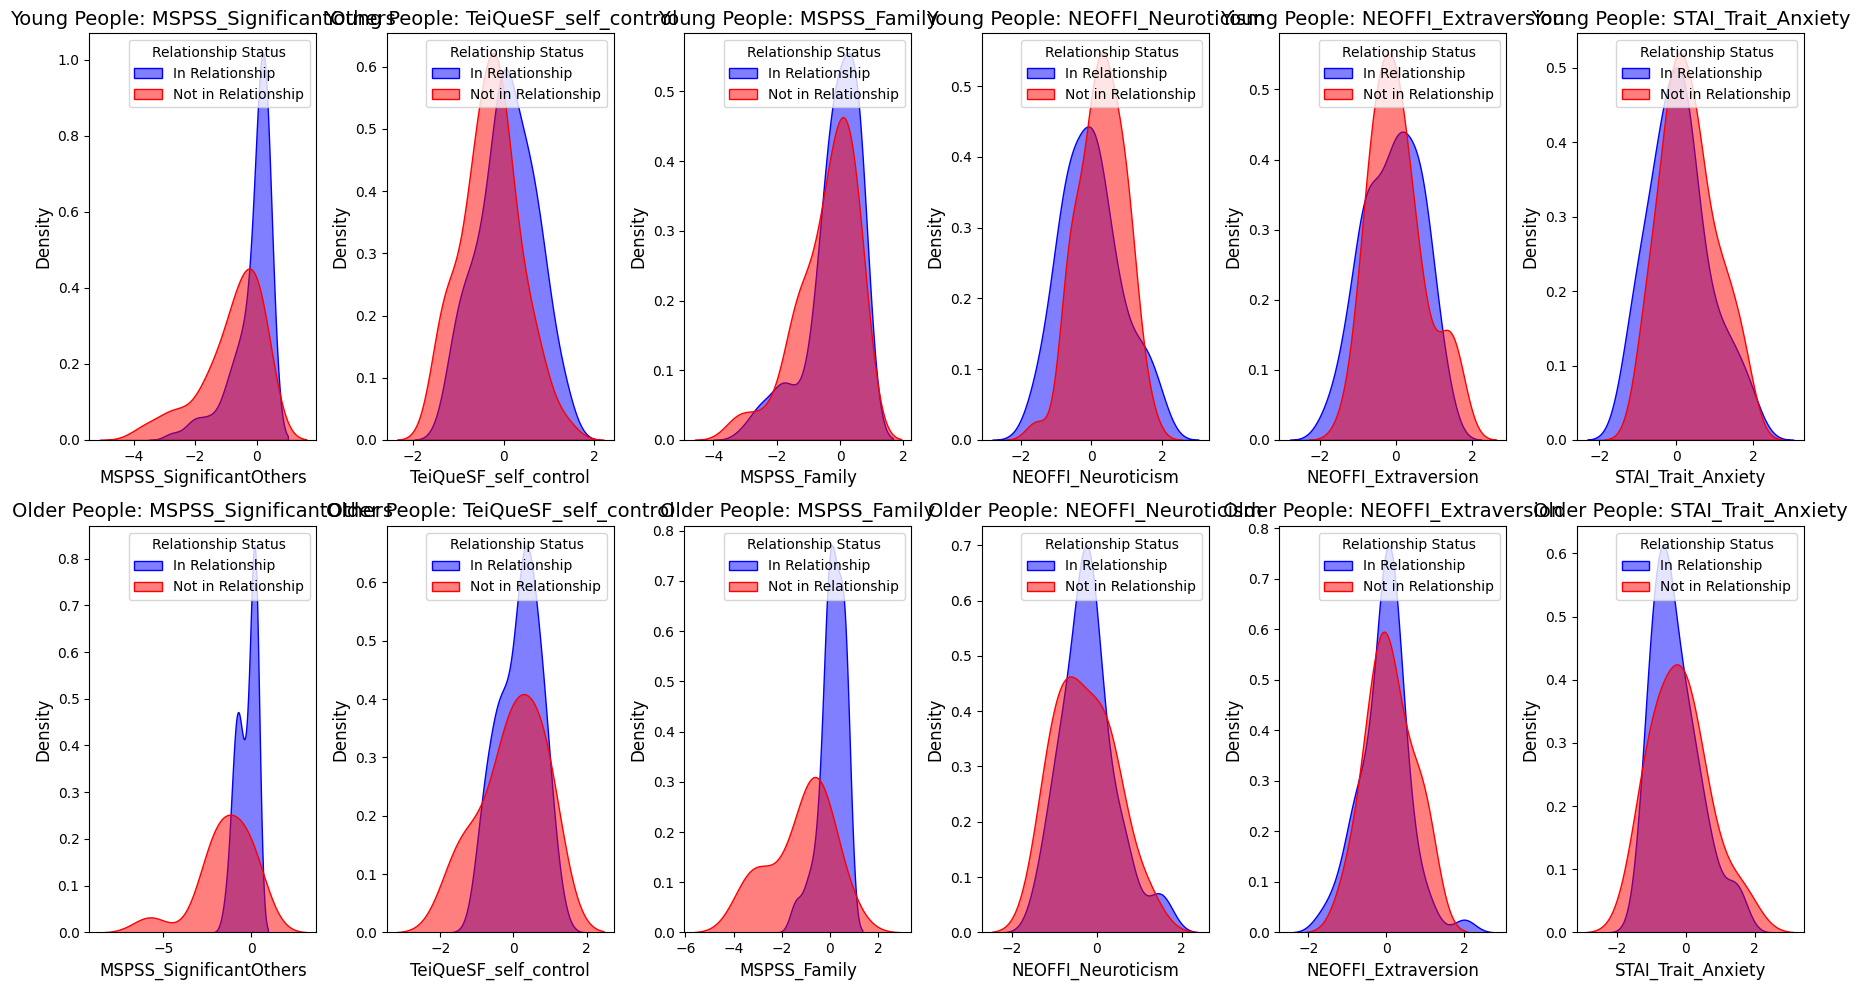

In [42]:
# Set up das Figure-Layout (2 Zeilen: Oben junge Leute, unten ältere)
fig, axes = plt.subplots(2, 6, figsize=(18, 10))

for i, feature in enumerate(top_6_features):
    # **Obere Zeile: Junge Leute (Age Group = 0)**
    ax1 = axes[0, i]
    
    sns.kdeplot(
        merged_data_clean_scaled_dataframe[
            (merged_data_clean_scaled_dataframe["Age_Group"] == 0) & 
            (merged_data_clean_scaled_dataframe["Relationship_Status"] == 1)
        ][feature], 
        label="In Relationship", fill=True, alpha=0.5, color="blue", ax=ax1
    )

    sns.kdeplot(
        merged_data_clean_scaled_dataframe[
            (merged_data_clean_scaled_dataframe["Age_Group"] == 0) & 
            (merged_data_clean_scaled_dataframe["Relationship_Status"] == 0)
        ][feature], 
        label="Not in Relationship", fill=True, alpha=0.5, color="red", ax=ax1
    )

    ax1.set_title(f"Young People: {feature}", fontsize=14)
    ax1.set_xlabel(feature, fontsize=12)
    ax1.set_ylabel("Density", fontsize=12)
    ax1.legend(title="Relationship Status")


    # **Untere Zeile: Ältere Leute (Age Group = 1)**
    ax2 = axes[1, i]

    sns.kdeplot(
        merged_data_clean_scaled_dataframe[
            (merged_data_clean_scaled_dataframe["Age_Group"] == 1) & 
            (merged_data_clean_scaled_dataframe["Relationship_Status"] == 1)
        ][feature], 
        label="In Relationship", fill=True, alpha=0.5, color="blue", ax=ax2
    )

    sns.kdeplot(
        merged_data_clean_scaled_dataframe[
            (merged_data_clean_scaled_dataframe["Age_Group"] == 1) & 
            (merged_data_clean_scaled_dataframe["Relationship_Status"] == 0)
        ][feature], 
        label="Not in Relationship", fill=True, alpha=0.5, color="red", ax=ax2
    )

    ax2.set_title(f"Older People: {feature}", fontsize=14)
    ax2.set_xlabel(feature, fontsize=12)
    ax2.set_ylabel("Density", fontsize=12)
    ax2.legend(title="Relationship Status")

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

--------

## Final Report Vizualisations

/var/folders/zb/_v_3sbq938jftd_b07f5kpfm0000gn/T/ipykernel_12653/3182292144.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance['Feature'] = feature_importance['Feature'].replace(feature_name_mapping)


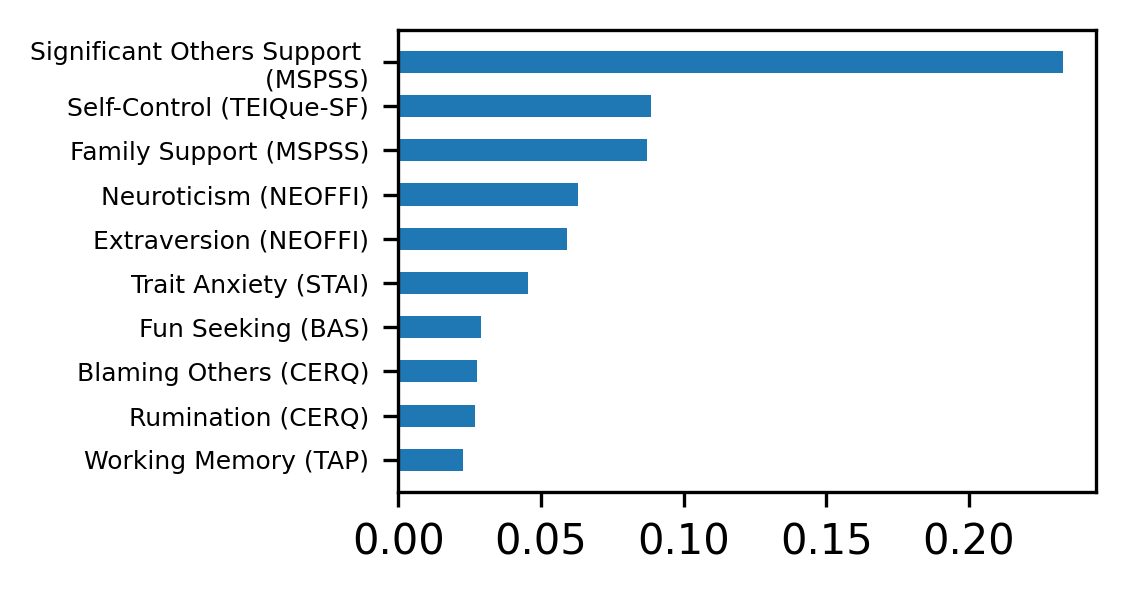

In [228]:
feature_name_mapping = {
    "STAI_Trait_Anxiety": "Trait Anxiety (STAI)",
    "NEOFFI_Neuroticism": "Neuroticism (NEOFFI)",
    "TeiQueSF_self_control": "Self-Control (TEIQue-SF)",
    "MSPSS_SignificantOthers": "Significant Others Support \n (MSPSS)",
    "MSPSS_Family": "Family Support (MSPSS)",
    "NEOFFI_Extraversion": "Extraversion (NEOFFI)",
    "BAS_Fun": "Fun Seeking (BAS)",
    "CERQ_BlamingOthers": "Blaming Others (CERQ)",
    "CERQ_Rumination": "Rumination (CERQ)",
    "TAP_WM_1": "Working Memory (TAP)"
}

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': merged_data_clean_scaled_dataframe.columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=True)

#feature_importances = feature_importances.head(10)
feature_importance = feature_importances[-10:]
feature_importance['Feature'] = feature_importance['Feature'].replace(feature_name_mapping)

# Plot
plt.figure(figsize=(3, 2), dpi=300)
plt.barh(feature_importance['Feature'], feature_importance['Importance'], height=0.5)
plt.yticks(fontsize=6) 
plt.show()

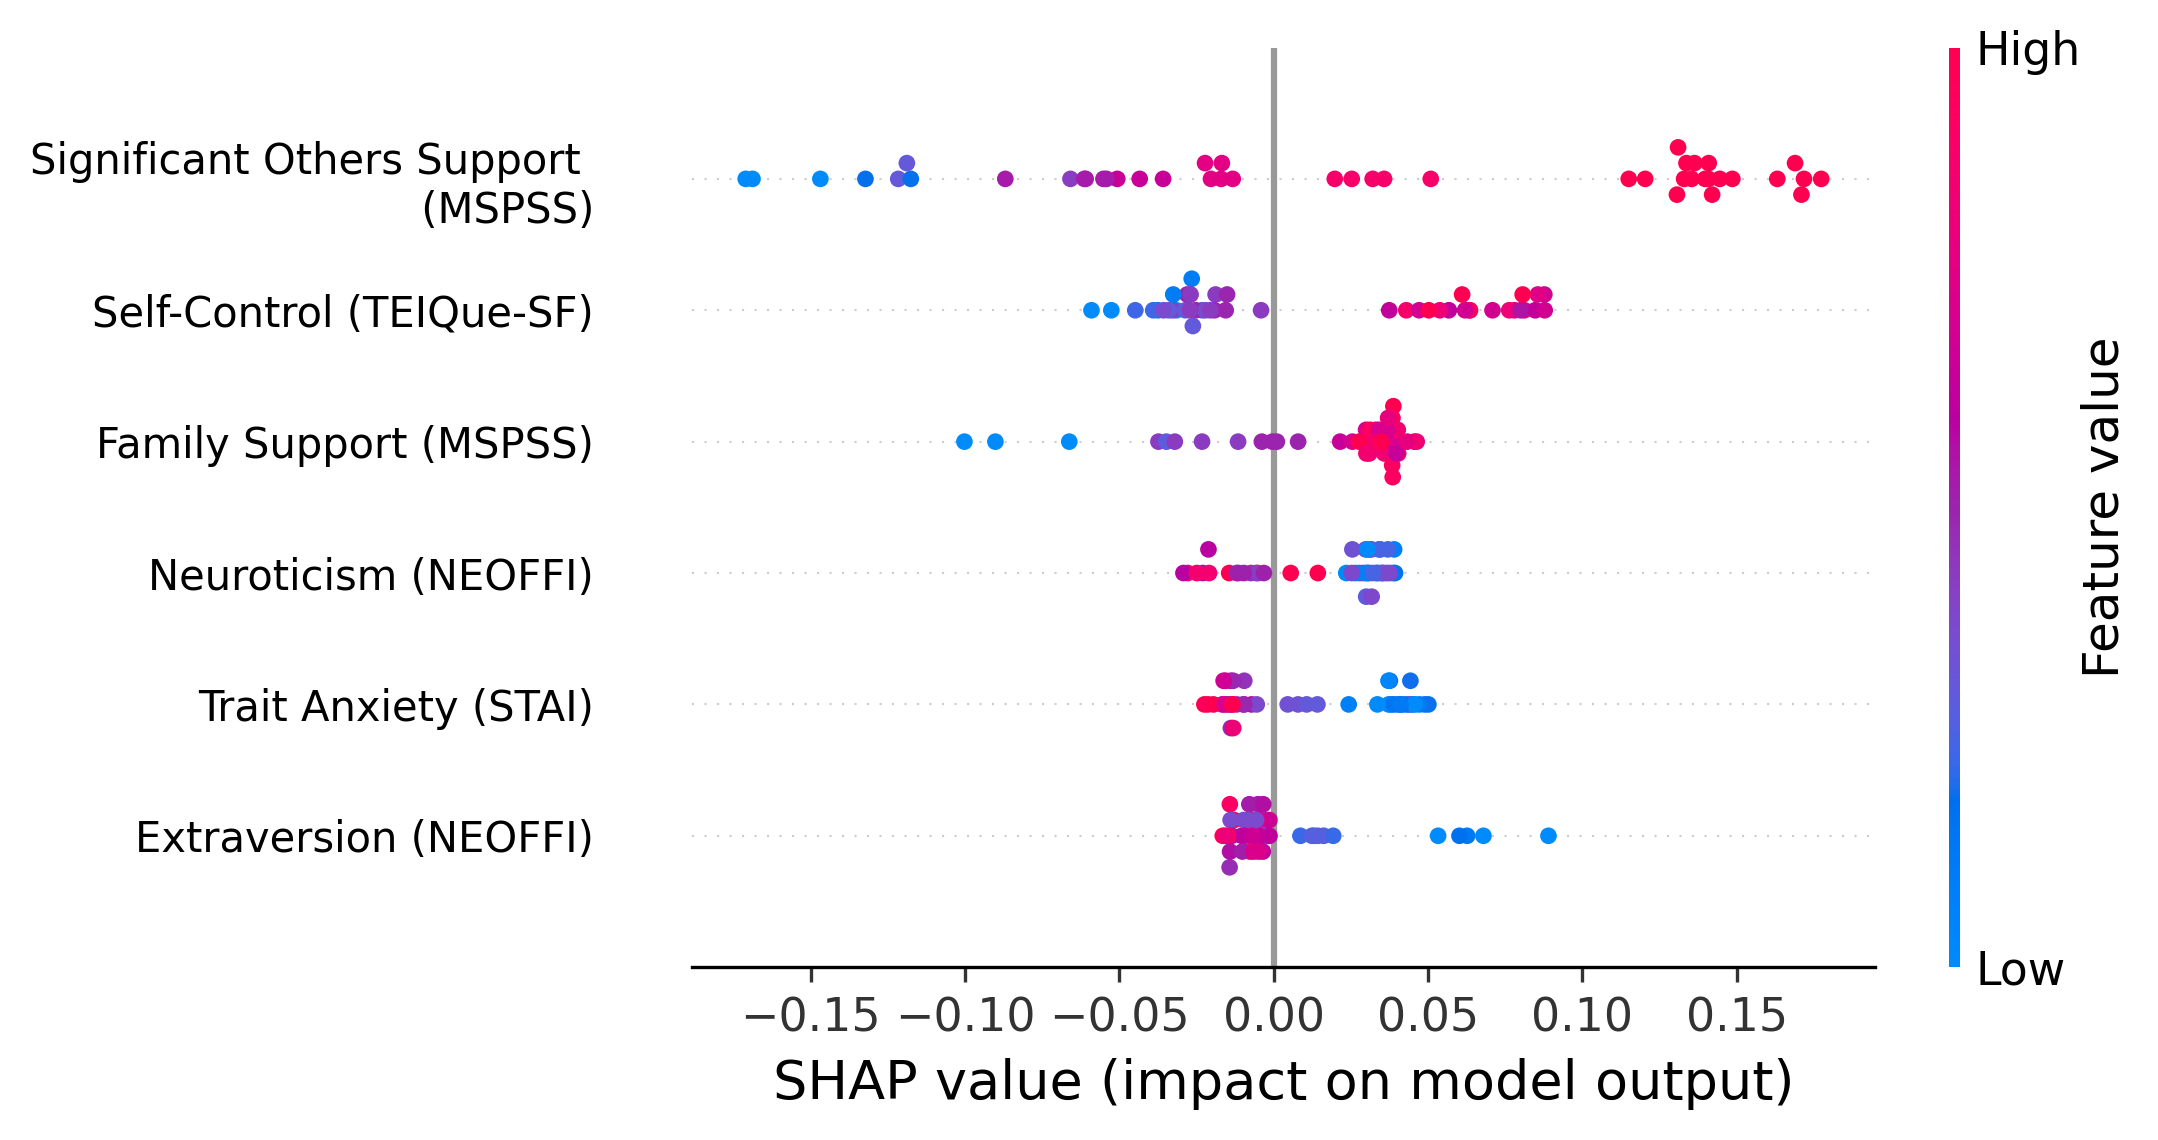

In [229]:
feature_name_mapping2 = {
    "STAI_Trait_Anxiety": "Trait Anxiety (STAI)",
    "NEOFFI_Neuroticism": "Neuroticism (NEOFFI)",
    "TeiQueSF_self_control": "Self-Control (TEIQue-SF)",
    "MSPSS_SignificantOthers": "Significant Others Support \n (MSPSS)",
    "MSPSS_Family": "Family Support (MSPSS)",
    "NEOFFI_Extraversion": "Extraversion (NEOFFI)"
}
X_test_dataframe = pd.DataFrame(X_test, columns=merged_data_clean_relevant.columns) 
X_test_dataframe_renamed = X_test_dataframe.rename(columns=feature_name_mapping)

# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Get SHAP values for the training set
shap_values = explainer.shap_values(X_test_dataframe_renamed)


# Create a SHAP explainer
explainer = shap.TreeExplainer(best_rf_model)

# Get SHAP values for the training set
shap_values = explainer.shap_values(X_test_dataframe_renamed)

plt.figure(figsize=(6, 6),dpi=300)  # Adjust figure size if needed
shap.summary_plot(
    shap_values[:,:,1], X_test_dataframe_renamed, max_display=6, show=False
)

# Modify y-axis (feature names) font size
plt.gca().tick_params(axis='y', labelsize=10, colors='black')  # Adjust '10' to desired font size
#plt.gca().tick_params(axis='x', labelsize=8) 

Top 3 Features for Analysis: ['MSPSS_SignificantOthers', 'TeiQueSF_self_control', 'MSPSS_Family', 'NEOFFI_Neuroticism', 'NEOFFI_Extraversion', 'STAI_Trait_Anxiety']


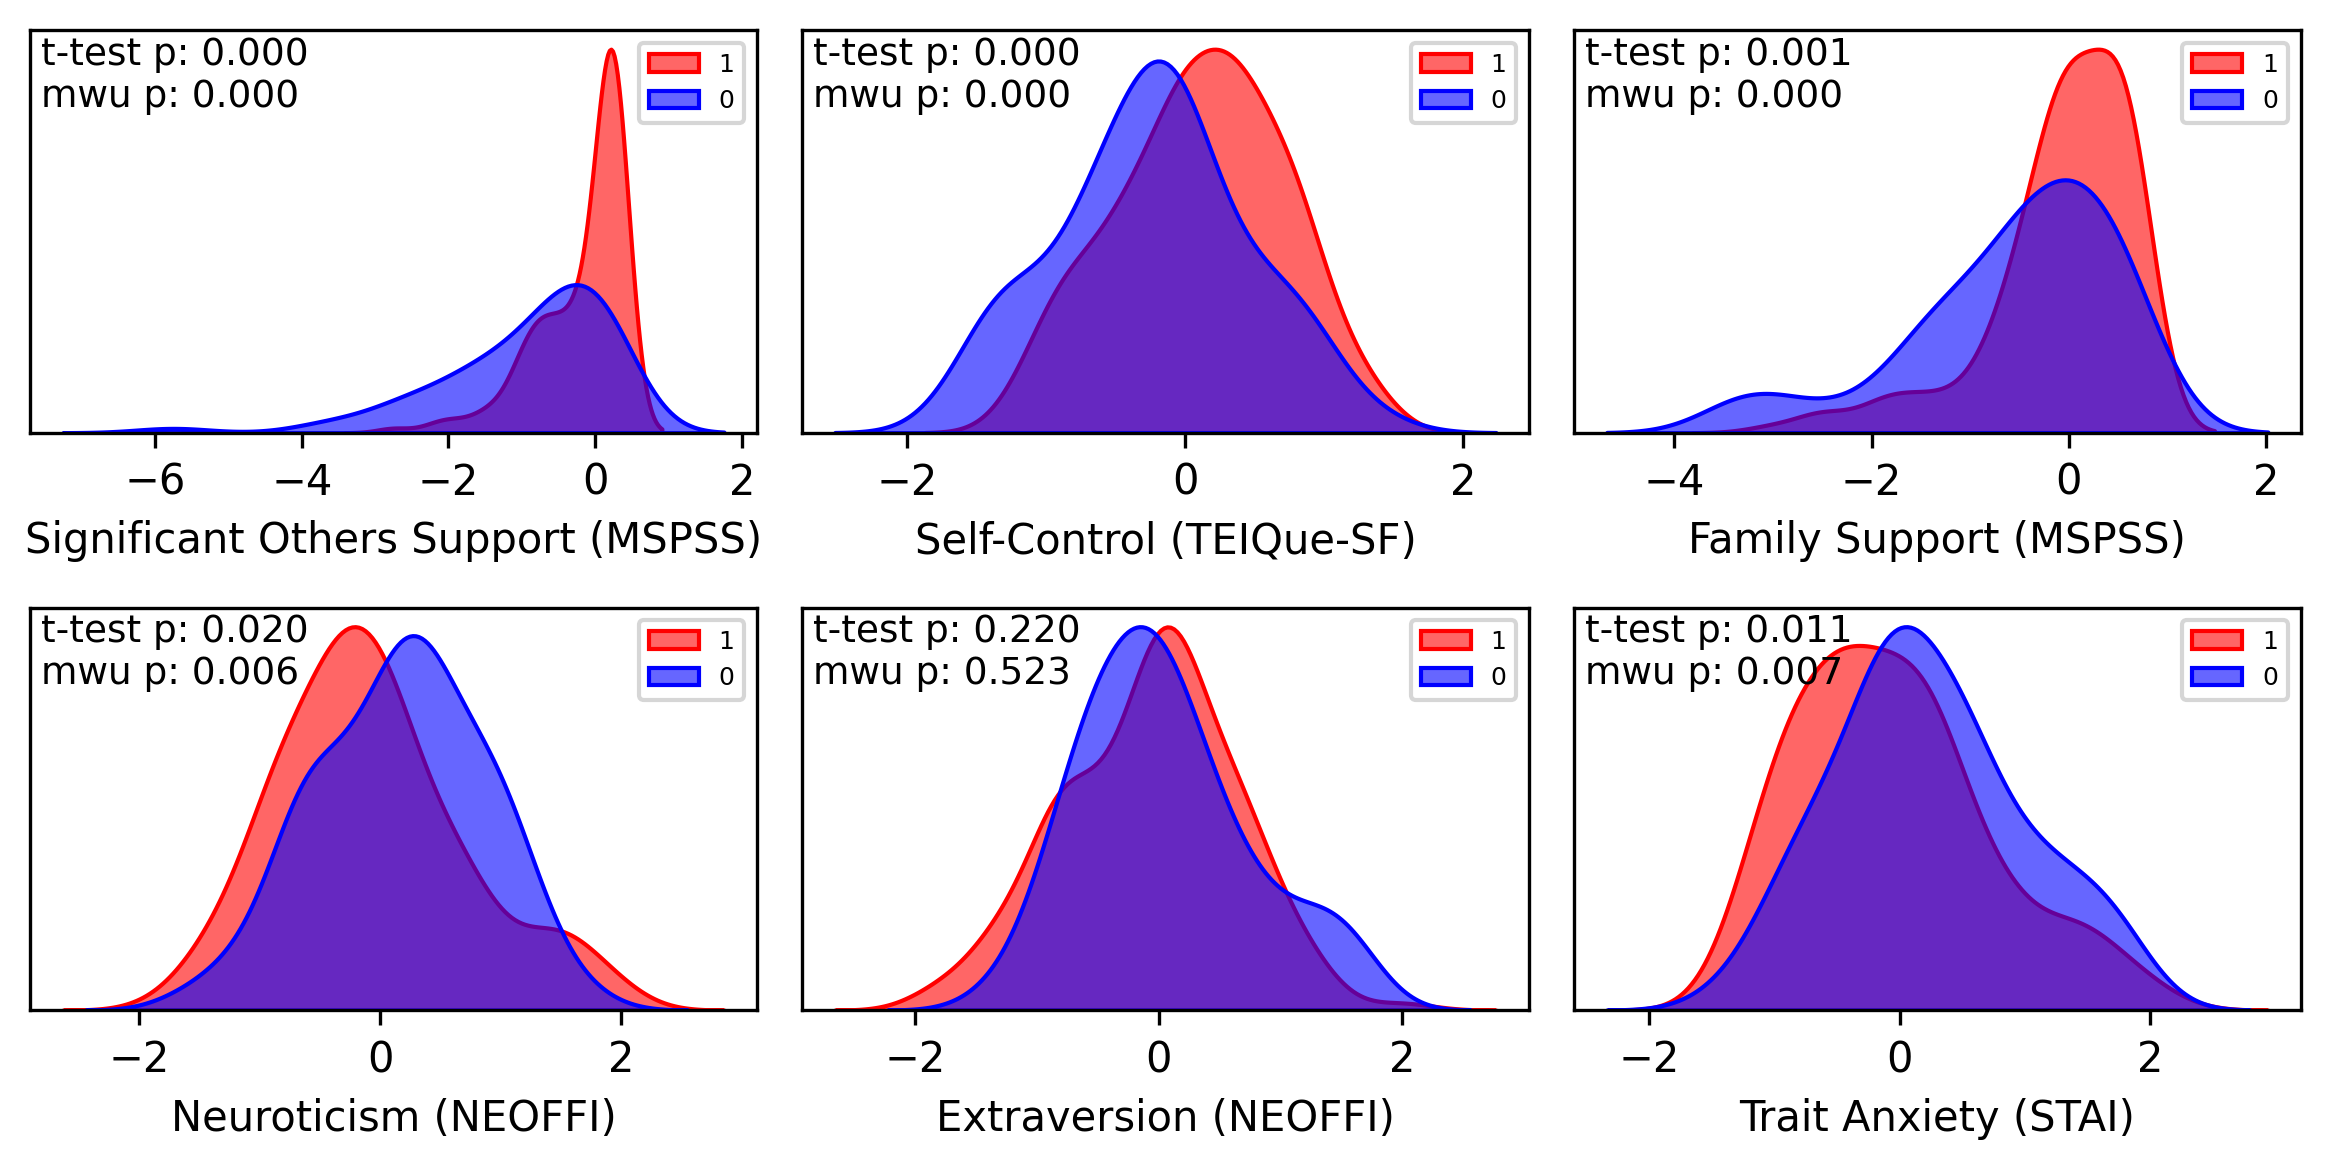

In [230]:
feature_name_mapping2 = {
    "STAI_Trait_Anxiety": "Trait Anxiety (STAI)",
    "NEOFFI_Neuroticism": "Neuroticism (NEOFFI)",
    "TeiQueSF_self_control": "Self-Control (TEIQue-SF)",
    "MSPSS_SignificantOthers": "Significant Others Support (MSPSS)",
    "MSPSS_Family": "Family Support (MSPSS)",
    "NEOFFI_Extraversion": "Extraversion (NEOFFI)"
}
# Extract top 6 feature names
top_6_features = feature_importances.sort_values(by="Importance", ascending=False)["Feature"][:6].tolist()
print("Top 3 Features for Analysis:", top_6_features)

# Set up the figure
plt.figure(figsize=(8, 4), dpi=300)

for i, feature in enumerate(top_6_features):
    plt.subplot(2, 3, i + 1)
    
    # Plot distribution for both groups
    sns.kdeplot(relationship_yes[feature], label="1", fill=True, alpha=0.6, color="red")
    sns.kdeplot(relationship_no[feature], label="0", fill=True, alpha=0.6, color="blue")

    feature_label = feature_name_mapping2.get(feature, feature) 
    
    # Add title and labels
    plt.xlabel(feature_label)
    plt.legend(fontsize=6, loc="upper right")

        # Retrieve p-value from dictionary
    p_value = results[feature]['p-value']
    p_value_whitney = results_mannwhitneyu[feature]['p-value']
    

    # Add p-values to the plot
    plt.text(
        0.015, 0.81, 
        f"t-test p: {p_value:.3f}\nmwu p: {p_value_whitney:.3f}",  # LaTeX for bold
        transform=plt.gca().transAxes, fontsize=9, color='black'
    )
    plt.gca().axes.get_yaxis().set_visible(False)  # Keep feature names visible
    f"T-Test: p = {p_value:.3f}\n MWU: p = **{p_value_whitney:.3f}**",

plt.tight_layout()
plt.show()